In [120]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

In [121]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
context_length = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 300
n_embd = 384
n_layers = 6
dropout = 0.2
n_heads = 6
rope_embeddings = True


In [122]:
with open('data/ai_corpus.txt') as file:
    movie_data = file.read()



In [123]:
ind = random.randint(0,len(movie_data)-1000)
print(movie_data[ind:ind+1000])

n integer for given actor, it means amount of items actor has
price - normalized price in given state.
BASE_PENALTY $ = -1$
INVALID_MOVE $ = -10$
False and True are indicating valid moves just for me.
if action == 0:
    &quot;BUY&quot;
    if discrete_stock == 0:
        return -price, True
    else:
        return INVALID_MOVE, False
elif action == 1:
    &quot;PASS&quot;
    return 3 * BASE_PENALTY, True
elif action == 2:
    &quot;SELL&quot;
    if discrete_stock &lt;= 0:
        return INVALID_MOVE, False
    return price * 2, True
More about problem
I think it is already small learning rate. Should I go even lower learning rate and bigger batch size?
I am confused about this problem. You can see there are some -10 rewards in plot, so some outputs had invalid move, yet I don't see model to set any actions in that direction.
Is model learning?
Loss is going very low. So is my solution designed wrong?
@NeilSlater thanks again for help, I found the issue, I copied values from actions

In [124]:
from collections import Counter
char_counts = Counter()
char_counts.update(movie_data)
char_counts

Counter({'I': 47046,
         'n': 625419,
         ' ': 1919096,
         'P': 10421,
         'o': 675534,
         'r': 519164,
         't': 864299,
         'a': 719236,
         'l': 369105,
         '2': 17838,
         'w': 135833,
         'e': 1063796,
         's': 559704,
         'h': 374819,
         'A': 23168,
         "'": 26107,
         'c': 279598,
         'b': 124871,
         '"': 9847,
         'k': 57687,
         'i': 650849,
         'd': 282793,
         'y': 150165,
         'g': 176674,
         'u': 271006,
         'p': 206388,
         'x': 38319,
         '.': 108055,
         '\n': 78778,
         'm': 236245,
         'f': 181574,
         'z': 11618,
         'Q': 4486,
         ':': 17429,
         'W': 8007,
         'v': 92668,
         '?': 11183,
         ',': 104333,
         'U': 3329,
         'q': 22816,
         'T': 28208,
         '-': 32947,
         'S': 16138,
         '*': 4205,
         'L': 11400,
         '!': 1367,
         'F': 

### Removing extremely low frequency characters from vocabulary

In [125]:
remove_chars = {k for k,v in char_counts.items() if v<100}
remove_chars

{'<',
 '¡',
 '§',
 '¬',
 '\xad',
 '°',
 '±',
 '²',
 '³',
 '´',
 '·',
 '¹',
 'º',
 '»',
 '½',
 '¿',
 'É',
 '×',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'ç',
 'è',
 'é',
 'ê',
 'í',
 'ï',
 'ð',
 'ó',
 'õ',
 'ö',
 '÷',
 'ú',
 'ü',
 'ć',
 'č',
 'ę',
 'ł',
 'ō',
 'ő',
 'ɔ',
 'ə',
 'ɛ',
 'ɪ',
 'ɹ',
 'ˈ',
 'ː',
 '̶',
 'Α',
 'Δ',
 'Χ',
 'Ψ',
 'α',
 'β',
 'γ',
 'δ',
 'ε',
 'θ',
 'λ',
 'μ',
 'ξ',
 'π',
 'ρ',
 'σ',
 'φ',
 'ω',
 'ϵ',
 'л',
 'н',
 'о',
 'с',
 '\u2000',
 '\u200a',
 '\u200b',
 '\u200c',
 '‐',
 '‘',
 '„',
 '†',
 '…',
 '\u2028',
 '′',
 '\u2061',
 '₁',
 '₂',
 '€',
 'ℎ',
 'ℝ',
 '←',
 '→',
 '↓',
 '↖',
 '↗',
 '↙',
 '⇐',
 '⇒',
 '∀',
 '∃',
 '∅',
 '∆',
 '∈',
 '∏',
 '∑',
 '∗',
 '√',
 '∞',
 '∣',
 '∧',
 '∨',
 '∪',
 '∫',
 '∼',
 '≈',
 '≡',
 '≤',
 '≥',
 '≪',
 '≫',
 '⊇',
 '⋅',
 '┆',
 '┌',
 '┐',
 '└',
 '┘',
 '┬',
 '┴',
 '▽',
 '●',
 '◦',
 '✅',
 '❌',
 '➡',
 '⟨',
 '⟩',
 '⬈',
 '⭕',
 '一',
 '个',
 '义',
 '定',
 '無',
 'ﬀ',
 'ﬁ',
 'ﬂ',
 'ﬃ',
 '，',
 '：'}

In [126]:
data = re.sub(f"[{''.join(remove_chars)}]",' ' , movie_data)
data = re.sub(r" +", " ", data)
data = re.sub(r"\n+", "\n", data)

In [127]:
# Getting the vocabulary of characters
chars = sorted(list(set(data)))
vocab_size = len(chars)
print(f'vocab_size: {vocab_size}')
print(f"unique_charcters: {''.join(chars)}")
print(f'Total characters in data: {len(data)}')

# Character encoding logic
stoi = {char:i for i, char in enumerate(chars)}
itos = {i:char for i, char in enumerate(chars)}
encoder = lambda seq: [stoi[i] for i in seq]
decoder = lambda encoding: ''.join([itos[i] for i in encoding])

# Encoding the data
data = torch.tensor(encoder(data), dtype=torch.long)


# Train-test split
train, test = data[:int(0.9*len(data))], data[int(0.9*len(data)):]

vocab_size: 104
unique_charcters: 
 !"#$%&'()*+,-./0123456789:;=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ –—’“”−─│
Total characters in data: 11635783


In [128]:
# Getting a sample batch from the data split
def get_batch_with_pos(split, batch_size, context_length):
    if split == 'train':
        data = train
    else:
        data = test
        
    #getting random starting indices for the batch_size
    start_indices = torch.randint(
        len(data) - context_length - 1,
        (batch_size,)
    )
    x_y = torch.stack([data[i:i+context_length+1]for i in start_indices], dim=0)
    x, y = x_y[:,:-1], x_y[:,1:]    
    pos = torch.arange(batch_size * context_length).reshape(batch_size, context_length) % context_length
    x, pos, y = x.to(device), pos.to(device), y.to(device)
    return x, pos, y

x, pos, y = get_batch_with_pos('train', 4, context_length)
x, pos, y


(tensor([[82, 73, 78,  ..., 78, 65, 76],
         [77, 69, 78,  ..., 82, 68,  1],
         [ 1, 34, 85,  ...,  1, 76, 69],
         [79, 78,  1,  ..., 17, 17, 13]]),
 tensor([[  0,   1,   2,  ..., 253, 254, 255],
         [  0,   1,   2,  ..., 253, 254, 255],
         [  0,   1,   2,  ..., 253, 254, 255],
         [  0,   1,   2,  ..., 253, 254, 255]]),
 tensor([[73, 78, 71,  ..., 65, 76,  1],
         [69, 78, 84,  ..., 68,  1,  7],
         [34, 85, 84,  ..., 76, 69, 84],
         [78,  1, 79,  ..., 17, 13,  1]]))

In [129]:
class RoPE(nn.Module):
    def __init__(self, base, dim, max_seq_len):
        super(RoPE, self).__init__()
        theta = base ** -(torch.arange(0,dim,2)/dim)
        pos = torch.arange(max_seq_len)
        freq = torch.einsum('i,j->ij', pos, theta)
        self.register_buffer('cos', freq.cos())
        self.register_buffer('sin', freq.sin())
    def forward(self, x):
        B, S, _ = x.shape
        cos = self.cos[:S]
        sin = self.sin[:S]
        a, b = x[:,:,::2], x[:,:,1::2]
        a_cos, b_cos, a_sin, b_sin = a * cos, b * cos, a * sin, b * sin
        # rot(a,b) = a cos(theta) - b sin(theta), a sin(theta) + b cos(theta)
        rot_1, rot_2 = a_cos - b_sin, a_sin + b_cos
        rot = torch.stack((rot_1, rot_2), -1)
        rot_embd = rot.reshape(B, S, -1)
        return rot_embd
        

In [130]:
class FeedFroward(nn.Module):
    def __init__(self, n_embd):
        super(FeedFroward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd*4),
            nn.ReLU(),
            nn.Linear(n_embd*4, n_embd),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
    

class AttentionHead(nn.Module):
    def __init__(self, head_dim):
        super(AttentionHead, self).__init__()
        self.head_dim = head_dim
        self.query = nn.Linear(n_embd, self.head_dim) #(B,S,C)
        self.key = nn.Linear(n_embd, self.head_dim) #(B,S,C)
        self.value = nn.Linear(n_embd, self.head_dim) #(B,S,C)
        self.register_buffer('tril', torch.tril(torch.ones(context_length,context_length)))
        self.dropout = nn.Dropout(dropout)
        if rope_embeddings:
            self.rope = RoPE(1e4, head_dim, 2048)

    def forward(self, embed, verbose=False):
        q = self.query(embed)
        k = self.key(embed)
        v = self.value(embed)
        if rope_embeddings:
            q = self.rope(q)
            k = self.rope(k)
        a = q @ k.transpose(-2,-1) * self.head_dim**-0.5
        a = a.masked_fill(self.tril==0, float('-inf'))
        a = F.softmax(a, dim=-1)
        a = self.dropout(a)
        if verbose:
            print(a.shape)
            plt.imshow([[j.item() for j in i]for i in a[0]])

        output = a @ v
        return output


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super(MultiHeadAttention, self).__init__()
        self.heads = nn.ModuleList([AttentionHead(head_size) for i in range(n_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, idx, verbose = False):
        output =  torch.cat([head(idx, verbose) for head in self.heads], dim = -1)
        output =  self.proj(output)
        return self.dropout(output)


class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super(Block, self).__init__()
        self.mh_attn = MultiHeadAttention(n_heads, n_embd//n_heads)
        #self.mh_attn = MoEMultiheadAttention(n_heads, n_embd//n_heads)
        self.f_frwd = FeedFroward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self,x):
        x = self.ln1(x)
        x = x + self.mh_attn(x)
        x = self.ln2(x)
        x = x + self.f_frwd(x)
        return x
    

class PunjabiAttentionModel(nn.Module):
    def __init__(self):
        super(PunjabiAttentionModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(context_length, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_heads) for i in range(n_layers)])
        self.register_buffer('tril', torch.tril(torch.ones(context_length,context_length)))
        self.linear = nn.Linear(n_embd, vocab_size)
        self.norm = nn.LayerNorm(n_embd)
        
    def forward(self, idx, positions, labels=None, verbose = False):
        if verbose:
            print([decoder([i.item() for i in idx[0]])],'\n')
        idx = self.token_embedding(idx)
        if not rope_embeddings:
            pos_embed = self.position_embedding(positions)
            idx += pos_embed
        idx = self.blocks(idx)
        logits = self.linear(idx)
        
        if labels is None:
            loss = None
        else:
            B, S, E = logits.shape
            logits = logits.reshape(B * S, E)
            labels = labels.reshape(B*S)
            loss = F.cross_entropy(logits, labels)
        return logits, loss
        
    def generate(self, idx, pos, max_seq_length, sampling=True):
        for i in range(max_seq_length):
            logits, _ = self(idx[:,-context_length:], pos)
            logits = logits[:, -1, :]
            if sampling:
                probs = F.softmax(logits, -1)
                generated_char_ids = torch.multinomial(probs, 1)
                idx = torch.cat((idx, generated_char_ids),dim=1)
            else:
                generated_char_ids = logits.argmax(-1)
                idx = torch.cat((idx, generated_char_ids.unsqueeze(0).T),dim=1)
        return idx
    def generate_upgraded(self, idx, pos, max_seq_length, temperature=1.0, top_p=1.0, sampling=True):
        for i in range(max_seq_length):
            logits, _ = self(idx[:,-context_length:], pos)
            logits = logits[:, -1, :]

            # Apply temperature
            if temperature > 0:
                logits = logits / temperature

            if sampling:
                probs = F.softmax(logits, dim=-1)

                # Apply top_p (nucleus) sampling
                if top_p < 1.0:
                    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0
                    indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
                    probs = probs.masked_fill(indices_to_remove, 0.0)
                    probs = probs / probs.sum(dim=-1, keepdim=True)  # renormalize

                generated_char_ids = torch.multinomial(probs, 1)
                idx = torch.cat((idx, generated_char_ids), dim=1)
            else:
                generated_char_ids = logits.argmax(-1)
                idx = torch.cat((idx, generated_char_ids.unsqueeze(0).T), dim=1)

        return idx
    

In [131]:
@torch.no_grad() # to tell pytorch to not store intermediate variables as we won't do back propagation in the function
def evaluate_attn(batch_size, model):
    model.eval()
    losses = {}
    for split in ['train', 'eval']:
        x, pos, y = get_batch_with_pos(split, batch_size, context_length)
        _, loss = model(x, pos, y)
        losses[split] = loss.item()
    return losses


model_attn = PunjabiAttentionModel()
model_attn.to(device)
optimizer_attn = torch.optim.AdamW(model_attn.parameters(), lr = learning_rate)



    




In [19]:
for i in tqdm(range(max_iters)):
    if i % eval_interval == 0:
        losses = evaluate_attn(batch_size = eval_iters, model = model_attn)
        print(f'train loss: {losses["train"]}, eval_loss: {losses["eval"]}')
    x, pos, y = get_batch_with_pos('train', batch_size, context_length)
    _, loss = model_attn(x, pos, y)
    optimizer_attn.zero_grad()
    loss.backward()
    optimizer_attn.step()
print(loss.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

train loss: 4.776429653167725, eval_loss: 4.777175426483154


 10%|█         | 501/5000 [01:29<25:50,  2.90it/s]

train loss: 1.5461839437484741, eval_loss: 1.5966216325759888


 20%|██        | 1001/5000 [02:58<22:58,  2.90it/s]

train loss: 1.4050331115722656, eval_loss: 1.3915424346923828


 30%|███       | 1501/5000 [04:27<20:05,  2.90it/s]

train loss: 1.3361411094665527, eval_loss: 1.3208335638046265


 40%|████      | 2001/5000 [05:55<17:13,  2.90it/s]

train loss: 1.256089210510254, eval_loss: 1.2939963340759277


 50%|█████     | 2501/5000 [07:24<14:22,  2.90it/s]

train loss: 1.2292159795761108, eval_loss: 1.2875800132751465


 60%|██████    | 3001/5000 [08:52<11:29,  2.90it/s]

train loss: 1.2240582704544067, eval_loss: 1.2685086727142334


 70%|███████   | 3501/5000 [10:21<08:37,  2.89it/s]

train loss: 1.1578712463378906, eval_loss: 1.229555606842041


 80%|████████  | 4001/5000 [11:50<05:44,  2.90it/s]

train loss: 1.1746991872787476, eval_loss: 1.2010360956192017


 90%|█████████ | 4501/5000 [13:18<02:52,  2.90it/s]

train loss: 1.1457452774047852, eval_loss: 1.2265880107879639


100%|██████████| 5000/5000 [14:46<00:00,  5.64it/s]


1.1577863693237305


In [23]:
x,y,pos = get_batch_with_pos('eval',1,context_length)
context = decoder(i.item() for i in x[0])
print(context)

ep have exceeded the time limit so the episode ends. This also indicated that you have to bootstrap the Q value estimate.
terminated instead is when the agent have reached a terminal state, therefore the episode naturally ends. You should use both to under


In [24]:
gen_len = 500
output = model_attn.generate(x,pos, gen_len, True)
print(f'context: {context}')
generation = decoder([i.item() for i in output[0][-gen_len:]])
print(f'generation: {generation}')

context: ep have exceeded the time limit so the episode ends. This also indicated that you have to bootstrap the Q value estimate.
terminated instead is when the agent have reached a terminal state, therefore the episode naturally ends. You should use both to under
generation: stand, it performs matrix should found the complexity of capable input and one current input situation. This full create networks, although there, or it means when tackling the $\mathbf{x}$ is the next state.
The variation is the current static sequence is easily (if there a good update of note).
The performance detected from the discussion (or current one layers is entirely). We use a descriptor of multiple stopping from $X + \epsilon$ following&quot; (Some Visual will worried to the DQER. Inte


In [132]:
def generate_text(context, model, gen_len):
    pad = ''.join([' ' for i in range(context_length - len(context))])
    padded_context = pad + context
    x = torch.tensor([encoder(padded_context)], device = device)
    pos = torch.arange(context_length).unsqueeze(0)
    pos = pos.to(device)
    output = model.generate(x,pos, gen_len)
    print(f'context: {context}\n')
    generation = decoder([i.item() for i in output[0][-gen_len:]])
    print(f'generation: {generation}')
    return generation


In [38]:
gen = generate_text('How are you?', model_attn, 500)

context: How are you?

generation: 
I need to person this varue the data "I think you till the best way $b$, then you can evaluate weights with variance_ of the reward state $(th)$ outputs $R_t$ (training collection the odder.
As Win, the hidden maybe considering the WInd1500% of something espective to we
import answer, without waiting information problem.
ERIOWK and REILU Postly DRone's recommendation for action-space entropywhich humans definitely impocal, I was moving for all, it doesn't really lie in the region of 0 degrees c


In [43]:
gen = generate_text('Artificial intelligence and machine', model_attn, 500)

context: Artificial intelligence and machine

generation:  learning?
P) to be the work (
 [cquest architecture) &quot;randomness &quot;takly&quot; embedding in
from loop equations, if not what we define this ignoring the better q-first, tune for ask models based on the two image classify $[$p(s'|c||S,|s,a)$, and $\epsilon$-greedy closed Rootlin Frameworks - users for sentence that is finite value functions (say keys real vappital) and policy on the index approximation power.
This is that this point is contained Countropy when the same word images (in t


In [137]:
path = 'model/ai_model_5k_steps.pth'
#torch.save(model_attn.state_dict(), path)

In [138]:
model_loaded = PunjabiAttentionModel()
model_loaded.load_state_dict(torch.load(path,  map_location=device))
model_loaded.eval()

PunjabiAttentionModel(
  (token_embedding): Embedding(104, 384)
  (position_embedding): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (mh_attn): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x AttentionHead(
            (query): Linear(in_features=384, out_features=64, bias=True)
            (key): Linear(in_features=384, out_features=64, bias=True)
            (value): Linear(in_features=384, out_features=64, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
            (rope): RoPE()
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (f_frwd): FeedFroward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((38

In [46]:
gen = generate_text('NLP, Large language models (LLM)', model_loaded, 500)

context: NLP, Large language models (LLM)

generation:  into 
import $(L_\ 
\end{bmatrix}) = \\ su_{t = 1}{N} \rightarrow \mathbb{E}[n] + \gamma^n X$ and $\lambda\in\{q(1, \ldots,s)$$│
To percept, then containing representation of steeps different subcase and $j$ isn(perhapt $(Z|, 1)$). Once then $\gamma$ denote the old in $N_j$ would be $D$ and $1$. However, if you could also differ from multiple paper, or $L$):
$$V(s)$ the goal is module time, $\epsilon$ that models are used to $r(s, a, 0)$ is a condition of $\epsilon}$ then $\gamma$ conceptube a 


In [47]:
gen = generate_text('Transformer', model_loaded, 500)

context: Transformer

generation: , then the large negative would approximately carround by the visit function `aj = softmax(other loss) will help would we understand the ILL the question random, and when dontain keeping it will be used a convolution dangerous.. 
We timing an action step in a jown case you have an local reproductive complex from one of them would find this would call a time?
Supervised learning return length, from _ ir) your response. That is a run, have manager can be more basic mechanically there it can over t


## Woohoo, the model has succefully learned to YAP!

In [48]:
for i in tqdm(range(max_iters)):
    if i % eval_interval == 0:
        losses = evaluate_attn(batch_size = eval_iters, model = model_attn)
        print(f'train loss: {losses["train"]}, eval_loss: {losses["eval"]}')
    x, pos, y = get_batch_with_pos('train', batch_size, context_length)
    _, loss = model_attn(x, pos, y)
    optimizer_attn.zero_grad()
    loss.backward()
    optimizer_attn.step()
print(loss.item())

  0%|          | 1/5000 [00:00<58:16,  1.43it/s]

train loss: 1.1268360614776611, eval_loss: 1.1962356567382812


 10%|█         | 501/5000 [01:29<25:49,  2.90it/s]

train loss: 1.122773289680481, eval_loss: 1.1756556034088135


 20%|██        | 1001/5000 [02:57<22:59,  2.90it/s]

train loss: 1.1141284704208374, eval_loss: 1.1807650327682495


 30%|███       | 1501/5000 [04:26<20:05,  2.90it/s]

train loss: 1.1075068712234497, eval_loss: 1.2118185758590698


 40%|████      | 2001/5000 [05:54<17:14,  2.90it/s]

train loss: 1.0990971326828003, eval_loss: 1.1362547874450684


 50%|█████     | 2501/5000 [07:23<14:21,  2.90it/s]

train loss: 1.08599853515625, eval_loss: 1.159732460975647


 60%|██████    | 3001/5000 [08:51<11:29,  2.90it/s]

train loss: 1.080183744430542, eval_loss: 1.1591893434524536


 70%|███████   | 3501/5000 [10:20<08:36,  2.90it/s]

train loss: 1.074751615524292, eval_loss: 1.1685752868652344


 80%|████████  | 4001/5000 [11:49<05:44,  2.90it/s]

train loss: 1.0700061321258545, eval_loss: 1.1723171472549438


 90%|█████████ | 4501/5000 [13:17<02:51,  2.90it/s]

train loss: 1.0272647142410278, eval_loss: 1.1553329229354858


100%|██████████| 5000/5000 [14:45<00:00,  5.65it/s]


0.9859277009963989


In [133]:
path = 'model/ai_model_10k_steps.pth'
#torch.save(model_attn.state_dict(), path)

In [134]:
model_loaded = PunjabiAttentionModel()
model_loaded.load_state_dict(torch.load(path, map_location=device))
model_loaded.eval()

PunjabiAttentionModel(
  (token_embedding): Embedding(104, 384)
  (position_embedding): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (mh_attn): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x AttentionHead(
            (query): Linear(in_features=384, out_features=64, bias=True)
            (key): Linear(in_features=384, out_features=64, bias=True)
            (value): Linear(in_features=384, out_features=64, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
            (rope): RoPE()
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (f_frwd): FeedFroward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((38

In [52]:
gen = generate_text('AI and ', model_loaded, 500)

context: AI and 

generation: it encountered it to predict AMA while an AI, which has N would still be a collection. Hence a perceptron correlation.
These methods I understand and we compute the largest results that deep learning make sure that you think LSTMs to get explained by the words are memory. So, one appropriate network images that you want the problem. In theory, you also try and simpler speech-device the ratio of the 3 augmentation we are not 0, then can capturing the idea of 0.3; then linear function is the order


In [140]:
def generate_text(context, model, gen_len, temperature=1.0, top_p=1.0):
    pad = ''.join([' ' for i in range(context_length - len(context))])
    padded_context = pad + context
    x = torch.tensor([encoder(padded_context)], device = device)
    pos = torch.arange(context_length).unsqueeze(0)
    pos = pos.to(device)
    output = model.generate_upgraded(x,pos, gen_len, temperature, top_p)
    print(f'context: {context}\n')
    generation = decoder([i.item() for i in output[0][-gen_len:]])
    print(f'generation: {generation}')
    return generation


In [149]:
temperatures = [0.5, 1, 1.5]
top_p = [0.1, 0.3, 0.5, 0.6, 0.9]
for t in temperatures:
    for p in top_p:
        print(f"temperature: {t}, top_p: {p}\n")
        gen = generate_text('AI and machine', model_loaded, 500, temperature=t, top_p=p)
        print('----------------------------\n\n')

temperature: 0.5, top_p: 0.1

context: AI and machine

generation:  learning algorithms and the same state is a single action for the same time step in the same state in the same time. The problem is that the same as a single state and the same state is a single action space in the same state space in the same state and the same state is a single state and the same state is a single state and the same state is a single state and the same state is a single state and action that the model will be a single state and the same state is a single action space and the 
----------------------------


temperature: 0.5, top_p: 0.3

context: AI and machine

generation:  learning algorithms and the output is a continuous action space in the same time step in the same time. The problem is that the problem is that the same state is a continuous action space in the case of the problem in the same as a single state and the same state is a single action space and the same state is a single state and the

In [153]:
x, y, pos = get_batch_with_pos('test', 6, 256)

In [161]:
contexts = [decoder([j.item() for j in i]) for i in x]
for context in contexts:
    gen = generate_text(context, model_loaded, 256, temperature=1, top_p=0.5)
    print('------------------------\n')

context: e-force solutions that create only hype - it is obvious to me that with more computation, data and model capacity, a model trained to minimize some objective might perform better, but who cares if the generated text contains fewer errors or &quot;seems to 

generation: provide the next time step at the policy gradient into a single context of the model to solve the policy in the sense of the state is a positive of a convolution to perform a convolution for the same called the problem of possible and action that can be de
------------------------

context: ender?
The values need to be stored during each batch only, as the forward values are needed to calculate the gradients.
A relevant equation from back propagation is how to derive $\nabla_{z_j^{(k)}}J$, or the gradient of error function $J$ with respect to

generation:  the reward function $p_\pi$ where $x_i$ is a reward $i$ the depth of the problem in the same as a convolution of $y_i$ is the next state $x_t$ and $x_i$ and $

In [139]:
gen = generate_text('AI and ', model_loaded, 100)

context: AI and 

generation: something, if M intelligentax.
Concinclude Some using Connected UR * ard and for random. Essentially, the same features mean by the optimal value, especially up-by-clarifycase linear for weights and evolutions *N* simple* curves argument for all image deeplearning. However, the problem rectangly words, the learning model (separate for tweet longer and then clipping for your problem state).
Insearch case, it is back finding itself.
&quot;a paper Intron&quot; (axis without knowing action etc) is c


In [49]:
last_logits[0]

tensor([ 0.5697,  0.2498, -0.3047, -0.5448, -0.5410,  0.8568, -0.4991,  0.1679,
        -0.3779, -0.1210, -0.1450,  0.6663,  0.3774,  0.8255,  0.5919,  0.4672,
        -1.1712,  0.2417,  0.0509, -0.3119,  0.4026, -0.5967,  0.6641, -0.5662,
         0.3841, -0.4602, -0.4926,  0.1171,  0.4809,  0.0376,  0.2115,  0.9371,
        -0.0817, -0.6111, -0.0407, -0.3396,  0.0108, -0.6285, -1.0472, -1.2361,
         0.1221,  0.7897, -0.9812, -0.7271, -0.0184,  0.5605,  0.7131,  1.6568,
        -0.5996,  0.0499,  0.1793,  0.6818,  0.4649,  0.4592,  0.0977,  0.4875,
        -0.2542, -0.4355, -0.8222, -0.4712, -1.7023,  0.0223,  0.1061, -0.2641,
         0.3260,  0.4232, -0.2637,  0.0819, -0.3178, -0.1890, -1.4600,  0.4860,
        -0.1431,  1.4096,  0.5978, -0.0707, -0.2015, -1.2384,  0.3305,  0.0857,
         0.0065, -0.1367,  0.3823, -0.4993, -0.7677,  0.3216,  0.4791, -1.2550,
         0.3929,  0.6452, -0.9320,  0.1709,  0.4395,  0.0556,  0.7812,  1.0457,
         0.7088,  1.3041, -0.9440, -0.30

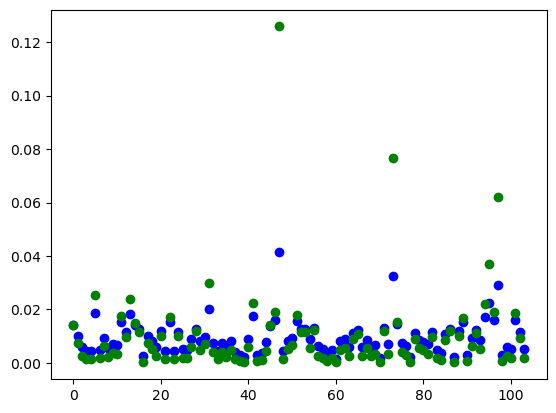

In [52]:
import matplotlib.pyplot as plt
temp = 0.5

plt.scatter(range(last_logits.shape[1]), [i.item() for i in F.softmax(last_logits[0], dim=-1)], color = 'blue')
plt.scatter(range(last_logits.shape[1]), [i.item() for i in F.softmax(last_logits[0]/temp, dim=-1)], color='green')

In [53]:
soft = F.softmax(last_logits[0], dim=-1)
soft

tensor([0.0140, 0.0102, 0.0059, 0.0046, 0.0046, 0.0187, 0.0048, 0.0094, 0.0054,
        0.0070, 0.0069, 0.0155, 0.0116, 0.0181, 0.0143, 0.0127, 0.0025, 0.0101,
        0.0084, 0.0058, 0.0119, 0.0044, 0.0154, 0.0045, 0.0117, 0.0050, 0.0049,
        0.0089, 0.0128, 0.0082, 0.0098, 0.0203, 0.0073, 0.0043, 0.0076, 0.0057,
        0.0080, 0.0042, 0.0028, 0.0023, 0.0090, 0.0175, 0.0030, 0.0038, 0.0078,
        0.0139, 0.0162, 0.0416, 0.0044, 0.0083, 0.0095, 0.0157, 0.0126, 0.0126,
        0.0088, 0.0129, 0.0062, 0.0051, 0.0035, 0.0050, 0.0014, 0.0081, 0.0088,
        0.0061, 0.0110, 0.0121, 0.0061, 0.0086, 0.0058, 0.0066, 0.0018, 0.0129,
        0.0069, 0.0325, 0.0144, 0.0074, 0.0065, 0.0023, 0.0110, 0.0086, 0.0080,
        0.0069, 0.0116, 0.0048, 0.0037, 0.0110, 0.0128, 0.0023, 0.0118, 0.0151,
        0.0031, 0.0094, 0.0123, 0.0084, 0.0173, 0.0226, 0.0161, 0.0292, 0.0031,
        0.0058, 0.0052, 0.0160, 0.0114, 0.0050], grad_fn=<SoftmaxBackward0>)

In [54]:
last_logits[0]/0.5

tensor([ 1.1395,  0.4997, -0.6093, -1.0897, -1.0819,  1.7136, -0.9981,  0.3359,
        -0.7559, -0.2421, -0.2899,  1.3326,  0.7547,  1.6509,  1.1838,  0.9344,
        -2.3424,  0.4835,  0.1019, -0.6238,  0.8052, -1.1934,  1.3282, -1.1325,
         0.7682, -0.9204, -0.9851,  0.2342,  0.9618,  0.0752,  0.4229,  1.8741,
        -0.1635, -1.2223, -0.0814, -0.6792,  0.0215, -1.2570, -2.0945, -2.4722,
         0.2442,  1.5794, -1.9624, -1.4543, -0.0369,  1.1209,  1.4261,  3.3136,
        -1.1991,  0.0998,  0.3586,  1.3635,  0.9297,  0.9183,  0.1955,  0.9749,
        -0.5084, -0.8710, -1.6445, -0.9425, -3.4045,  0.0446,  0.2123, -0.5281,
         0.6520,  0.8463, -0.5274,  0.1638, -0.6357, -0.3781, -2.9201,  0.9720,
        -0.2862,  2.8192,  1.1957, -0.1414, -0.4029, -2.4767,  0.6609,  0.1713,
         0.0130, -0.2735,  0.7645, -0.9987, -1.5354,  0.6432,  0.9582, -2.5100,
         0.7858,  1.2904, -1.8640,  0.3417,  0.8789,  0.1111,  1.5623,  2.0915,
         1.4177,  2.6081, -1.8881, -0.61

In [55]:
sorted_probs, sorted_indices = torch.sort(soft, descending=True)
sorted_probs, sorted_indices

(tensor([0.0416, 0.0325, 0.0292, 0.0226, 0.0203, 0.0187, 0.0181, 0.0175, 0.0173,
         0.0162, 0.0161, 0.0160, 0.0157, 0.0155, 0.0154, 0.0151, 0.0144, 0.0143,
         0.0140, 0.0139, 0.0129, 0.0129, 0.0128, 0.0128, 0.0127, 0.0126, 0.0126,
         0.0123, 0.0121, 0.0119, 0.0118, 0.0117, 0.0116, 0.0116, 0.0114, 0.0110,
         0.0110, 0.0110, 0.0102, 0.0101, 0.0098, 0.0095, 0.0094, 0.0094, 0.0090,
         0.0089, 0.0088, 0.0088, 0.0086, 0.0086, 0.0084, 0.0084, 0.0083, 0.0082,
         0.0081, 0.0080, 0.0080, 0.0078, 0.0076, 0.0074, 0.0073, 0.0070, 0.0069,
         0.0069, 0.0069, 0.0066, 0.0065, 0.0062, 0.0061, 0.0061, 0.0059, 0.0058,
         0.0058, 0.0058, 0.0057, 0.0054, 0.0052, 0.0051, 0.0050, 0.0050, 0.0050,
         0.0049, 0.0048, 0.0048, 0.0046, 0.0046, 0.0045, 0.0044, 0.0044, 0.0043,
         0.0042, 0.0038, 0.0037, 0.0035, 0.0031, 0.0031, 0.0030, 0.0028, 0.0025,
         0.0023, 0.0023, 0.0023, 0.0018, 0.0014], grad_fn=<SortBackward0>),
 tensor([ 47,  73,  97,  95,  31,

In [58]:
cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
cumulative_probs

tensor([0.0416, 0.0741, 0.1034, 0.1260, 0.1462, 0.1649, 0.1830, 0.2005, 0.2179,
        0.2341, 0.2502, 0.2662, 0.2819, 0.2973, 0.3128, 0.3279, 0.3423, 0.3567,
        0.3707, 0.3846, 0.3975, 0.4104, 0.4233, 0.4361, 0.4488, 0.4614, 0.4740,
        0.4863, 0.4984, 0.5103, 0.5220, 0.5337, 0.5453, 0.5569, 0.5683, 0.5794,
        0.5903, 0.6013, 0.6115, 0.6216, 0.6314, 0.6409, 0.6503, 0.6597, 0.6687,
        0.6776, 0.6864, 0.6952, 0.7038, 0.7125, 0.7208, 0.7292, 0.7375, 0.7458,
        0.7539, 0.7619, 0.7699, 0.7777, 0.7853, 0.7927, 0.8001, 0.8071, 0.8140,
        0.8209, 0.8278, 0.8343, 0.8408, 0.8470, 0.8531, 0.8592, 0.8650, 0.8709,
        0.8767, 0.8825, 0.8881, 0.8936, 0.8987, 0.9039, 0.9089, 0.9139, 0.9189,
        0.9237, 0.9286, 0.9334, 0.9380, 0.9426, 0.9471, 0.9515, 0.9558, 0.9602,
        0.9644, 0.9682, 0.9719, 0.9754, 0.9785, 0.9816, 0.9846, 0.9874, 0.9898,
        0.9921, 0.9944, 0.9967, 0.9986, 1.0000], grad_fn=<CumsumBackward0>)

In [59]:
sorted_indices_to_remove = cumulative_probs > 0.3
sorted_indices_to_remove

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True])

In [60]:
sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
sorted_indices_to_remove[..., 0] = 0
sorted_indices_to_remove

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True])

In [61]:
indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
indices_to_remove      

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True, False, False,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False,  True,  True,
         True, False,  True,  True])

In [62]:
probs = soft.masked_fill(indices_to_remove, 0.0)
soft, probs

(tensor([0.0140, 0.0102, 0.0059, 0.0046, 0.0046, 0.0187, 0.0048, 0.0094, 0.0054,
         0.0070, 0.0069, 0.0155, 0.0116, 0.0181, 0.0143, 0.0127, 0.0025, 0.0101,
         0.0084, 0.0058, 0.0119, 0.0044, 0.0154, 0.0045, 0.0117, 0.0050, 0.0049,
         0.0089, 0.0128, 0.0082, 0.0098, 0.0203, 0.0073, 0.0043, 0.0076, 0.0057,
         0.0080, 0.0042, 0.0028, 0.0023, 0.0090, 0.0175, 0.0030, 0.0038, 0.0078,
         0.0139, 0.0162, 0.0416, 0.0044, 0.0083, 0.0095, 0.0157, 0.0126, 0.0126,
         0.0088, 0.0129, 0.0062, 0.0051, 0.0035, 0.0050, 0.0014, 0.0081, 0.0088,
         0.0061, 0.0110, 0.0121, 0.0061, 0.0086, 0.0058, 0.0066, 0.0018, 0.0129,
         0.0069, 0.0325, 0.0144, 0.0074, 0.0065, 0.0023, 0.0110, 0.0086, 0.0080,
         0.0069, 0.0116, 0.0048, 0.0037, 0.0110, 0.0128, 0.0023, 0.0118, 0.0151,
         0.0031, 0.0094, 0.0123, 0.0084, 0.0173, 0.0226, 0.0161, 0.0292, 0.0031,
         0.0058, 0.0052, 0.0160, 0.0114, 0.0050], grad_fn=<SoftmaxBackward0>),
 tensor([0.0000, 0.0000, 0.000

In [63]:
scale_prob = probs = probs / probs.sum(dim=-1, keepdim=True)
scale_prob

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0598, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0494, 0.0000, 0.0579, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0493, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0648, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0559, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0518, 0.1331, 0.0000, 0.0000, 0.0000, 0.0502, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0554, 0.0722, 0.0516, 0.0935, 0.0000,
        0.0000, 0.0000, 0.0511, 0.0000, 0.0000], grad_fn=<DivBackward0>)

In [86]:
scale_prob[73], scale_prob[97], scale_prob[47], scale_prob[22], scale_prob[31], scale_prob[46], soft[0]

(tensor(0.1039, grad_fn=<SelectBackward0>),
 tensor(0.0935, grad_fn=<SelectBackward0>),
 tensor(0.1331, grad_fn=<SelectBackward0>),
 tensor(0.0493, grad_fn=<SelectBackward0>),
 tensor(0.0648, grad_fn=<SelectBackward0>),
 tensor(0.0518, grad_fn=<SelectBackward0>),
 tensor(0.0140, grad_fn=<SelectBackward0>))

In [85]:
torch.multinomial(soft, 1)

tensor([0])

In [ ]:
 cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
                probs = probs.masked_fill(indices_to_remove, 0.0)
                probs = probs / probs.sum(dim=-1, keepdim=True)

In [ ]:
import torch
import torch.nn.functional as F

def generate(self, idx, pos, max_seq_length, temperature=1.0, top_p=1.0, sampling=True):
    for i in range(max_seq_length):
        logits, _ = self(idx[:,-context_length:], pos)
        logits = logits[:, -1, :]
        
        # Apply temperature
        logits = logits / temperature
        
        if sampling:
            probs = F.softmax(logits, dim=-1)
            
            # Apply top_p (nucleus) sampling
            if top_p < 1.0:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
                probs = probs.masked_fill(indices_to_remove, 0.0)
                probs = probs / probs.sum(dim=-1, keepdim=True)  # renormalize
            
            generated_char_ids = torch.multinomial(probs, 1)
            idx = torch.cat((idx, generated_char_ids), dim=1)
        else:
            generated_char_ids = logits.argmax(-1)
            idx = torch.cat((idx, generated_char_ids.unsqueeze(0).T), dim=1)
    
    return idx